# Metodi Actor-Critic - Coding

Mario Fiorino

One-step Actor-Critic (episodic) - testo di Sutton a pagina PDF 354.

$\;$

<div>
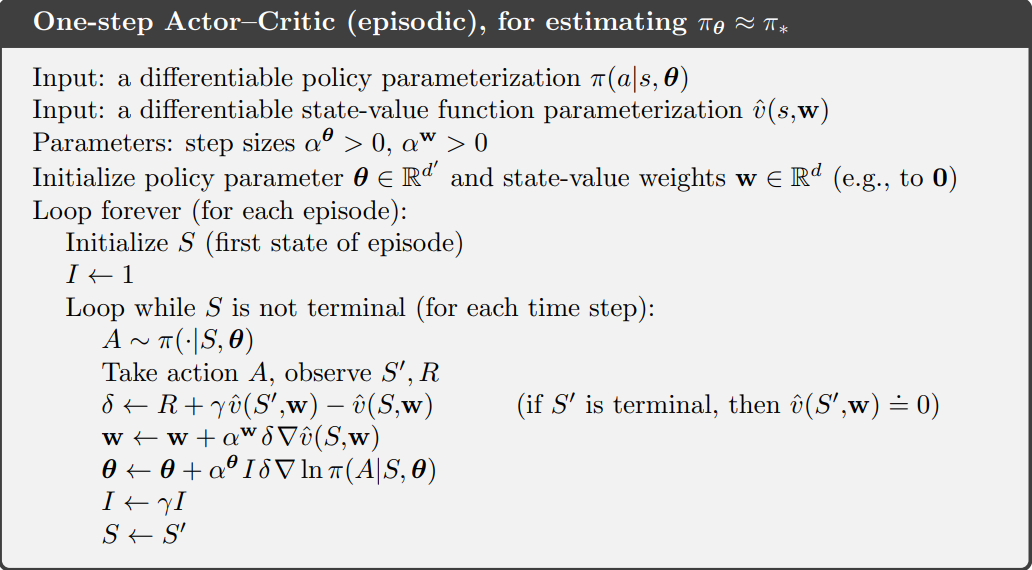
</div>

# Solving Pendulum with Advantage Actor Critic (A2C)  

## Env: Pendulum(Gym)


$\;$

https://www.gymlibrary.dev/environments/classic_control/pendulum/

https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81



Contesto: spazio continuo

L'obiettivo è applicare una momento meccanica: "Torque" (i cui valori sono continui nel range $[-2,2]$ ) al pendolo per farlo arrivare in posizione verticale, con il centro di gravità proprio sopra il punto fisso.


Di default, l'episodio viene troncato a 200 time step.

Il reward è calcolato in base ad un equazione matematica (vedi documentazione); la cui ricompensa minima che può essere ottenuta è  = -16,2736044, mentre la ricompensa massima è zero (il pendolo è verticale con velocità zero e nessuna coppia applicata).

In [ ]:
import gym
import warnings
warnings.filterwarnings('ignore')

env=gym.make('Pendulum-v1', g=10.00)
#help(env.unwrapped)

max_timeSteps=250


initial_state=env.reset()

for timeIndex in range(1,max_timeSteps+1):


        random_action=env.action_space.sample()

        observation, reward, done, info = env.step(random_action)
        if timeIndex < 3 or timeIndex >199:
          print("timeIndex=",timeIndex)
          print("random_action=",random_action)
          print("[cos(theta),sin(theta),Angular Velocity]",observation)
          print("reward=",reward)
          print("done=",done)
          print("info=",info)
          print("")

        if done:
            break

env.close()

timeIndex= 1
random_action= [0.1531318]
[cos(theta),sin(theta),Angular Velocity] [ 0.99329406  0.11561516 -0.7954545 ]
reward= -0.11161374703043334
done= False
info= {}

timeIndex= 2
random_action= [-1.3977523]
[cos(theta),sin(theta),Angular Velocity] [ 0.99755424  0.06989695 -0.91840595]
reward= -0.0786553455511236
done= False
info= {}

timeIndex= 200
random_action= [-1.3620377]
[cos(theta),sin(theta),Angular Velocity] [ 0.84243304 -0.538801   -0.54721636]
reward= -0.2954339366079233
done= True
info= {'TimeLimit.truncated': True}



## Moduli ed Inizilizzazione dell'ambiente


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

import random
import math
from typing import List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from IPython.display import clear_output

env=gym.make('Pendulum-v1', g=10.00)
#max_episode_steps=300

## Actor / Critic  ANNs

Saranno implementate due reti separate:

Actor network:

$s_t → \pi(a_t|s_t;\mathbf{θ}) = \mathcal{N} (μ(s_t), \sigma(s_t);\mathbf{θ} ) $

L' output della rete (ovvero quello che cerca di apprendere) è una distribuzione di probabilità continua sull' azione da intraprendere in un certo stato $s_t$, in input.

Questo si concretizza ricavando i parametri caratterizzanti di una distribuzione gaussiana, ovvero:
 - il valore della media $μ(s_t)$, interpretabile come il valore dell'azione più probabile in $s_t$
 - e la deviazione standard

Appresa la distribuzione di probabilità di azione (*action probability distribution*), se ne estrae un campione, corrispondente all'azione da eseguire.

Nota: è una comune implementazione l'utilizzo di una distribuzione normale (gaussiana) per rappresentare la distribuzione di probabilità di azioni continue (*parameterization for continuous actions*) dato un certo stato in input.

L'architettura della rete di Actor è costituita da uno strato nascosto fully connected con funzione di attivazione ReLU, che si ramifica in due strati di output fully connected; per "imparare" rispettivamente la media e la deviazione standard di una distribuzione normale.

L'ambiente Pendulum ha solo una singola azione con un intervallo compreso tra -2 e 2.
Per garantire che l'azione rientri in tale intervallo, l'Actor restituisce un valore medio $μ$ ottenuto da una moltiplicazione per 2 di tanh.
Si ricorda che  tanh normalizza l'output tra -1 e 1.

$\;$

Critic network:

$s_t → V(s_t;\mathbf{w})$


 genera in uscita una value-fuction.

In [ ]:
# Codice ispirato :
# https://github.com/MrSyee/pg-is-all-you-need
# https://colab.research.google.com/github/MrSyee/pg-is-all-you-need/blob/master/01.A2C.ipynb#scrollTo=A4iIMI_UeddW


def initialize_uniformly(layer: nn.Linear, init_w: float = 3e-3):
    """Tale funzione consente di inizializzare in modo uniforme pesi e bias
         in un intervallo di input pari a [-init_w, init_w]."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)


#ANN: Actor
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.mu_layer = nn.Linear(128, out_dim)
        self.log_std_layer = nn.Linear(128, out_dim)

        initialize_uniformly(self.mu_layer)
        initialize_uniformly(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:

        x = F.relu(self.hidden1(state))

        #Costruisce la distribuzione Gaussiana(mu, std)
        mu = torch.tanh(self.mu_layer(x)) * 2
        # Per un idea della forma di tanh
        #https://www.geeksforgeeks.org/python-pytorch-tanh-method/

        softplus = F.softplus(self.log_std_layer(x))
        # Softplus layer for actor or critic network
        # https://www.mathworks.com/help/reinforcement-learning/ref/rl.layer.softpluslayer.html
        std = torch.exp(softplus)

        distr_gauss = Normal(mu, std)

        #Estrae un azione dalla distribuzione Normale
        action = distr_gauss.sample()

        return action, distr_gauss


#ANN: Critic

class Critic(nn.Module):
    def __init__(self, in_dim: int):
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.out = nn.Linear(128, 1)

        initialize_uniformly(self.out)

    def swish_fn(self, x): # Swish (Swish-Net activation)
        return x * torch.sigmoid(x)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = self.hidden1(state)
        x = self.swish_fn(x)
        value = self.out(x)

        return value

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


####Verifica delle classi implementate

In [ ]:
#Testing Class

t_actor = Actor(env.observation_space.shape[0], env.action_space.shape[0])

st= [-0.6348567,   0.7726299,   0.29276827]

action, distr_gauss= t_actor(torch.FloatTensor(st))
print("action=",action)
print("")
#https://pytorch.org/docs/stable/distributions.html
print("distr_gauss=",distr_gauss)

print("distr_gauss.mean=",distr_gauss.mean) # 'Normal' object attribute/methods : mean, scale, sample(), log_prob()
print("distr_gauss.scale=",distr_gauss.scale) # sarebbe la std
c1 = distr_gauss.sample()
print("distr_gauss.sample=",c1)
print("distr_gauss.sample().clamp=",c1.clamp(min=-2.0, max=2.0).cpu().detach().numpy())
print("")

# .log_prob(value) Returns the log of the probability density/mass function evaluated at value.
log_probil = distr_gauss.log_prob(c1)
print(".log_probil(sample)=",log_probil)
log_probil = distr_gauss.log_prob(c1).sum(dim=-1) # stesso risultato con dim=0, esssendo un solo elemento
print(".log_probil(sample).sum(dim=-1)=",log_probil)
print(".log_probil(mean)=",distr_gauss.log_prob(distr_gauss.mean))


t_critic = Critic(env.observation_space.shape[0])
value_critic = t_critic(torch.FloatTensor(st))
print("\nvalue_critic=",value_critic)

action= tensor([-0.9731])

distr_gauss= Normal(loc: tensor([-0.0133], grad_fn=<MulBackward0>), scale: tensor([1.9982], grad_fn=<ExpBackward0>))
distr_gauss.mean= tensor([-0.0133], grad_fn=<MulBackward0>)
distr_gauss.scale= tensor([1.9982], grad_fn=<ExpBackward0>)
distr_gauss.sample= tensor([2.5272])
distr_gauss.sample().clamp= [2.]

.log_probil(sample)= tensor([-2.4194], grad_fn=<SubBackward0>)
.log_probil(sample).sum(dim=-1)= tensor(-2.4194, grad_fn=<SumBackward1>)
.log_probil(mean)= tensor([-1.6112], grad_fn=<SubBackward0>)

value_critic= tensor([-8.4092e-05], grad_fn=<ViewBackward0>)


#### Notazioni Tecniche

In [ ]:
#  "->"  è un Type Hints ovvero delle annotazioni,
# nello specifico è detto "Annotations for return type ""
# sono semplici suggerimenti sul tipo di data in uscita dalla funzione;
# Nono sono vincolanti durante l'esecuzione:
# "These expressions are evaluated at compile time and have no life in python’s runtime environment.
# Python does not attach any meaning to these annotations.
# They take life when interpreted by third party libraries, for example, mypy."

# Discorso analogo per ":", detto "Annotations for simple parameters"

#https://www.geeksforgeeks.org/function-annotations-python/
#Nell'esempio sotto si vuole evidenziare, mischiando un po le cose,
# che sono annotazioni, e che non condizionano il codice in esecuzione.
# Ad "n:int" posso dare anche un lista di float ed avere un ritorno dalla funzione diverso da "-> np.array"
def di(n:int=4) -> np.array:
  return sum(n *3)

d = di([1.2,7.7])
print(type(d))
print(d)

<class 'float'>
26.7


In [ ]:
#Python List extend() Method

tree = ['pino', 'quercia']
points = (0, 4, 9)
tree.extend(points)
print(tree)

['pino', 'quercia', 0, 4, 9]


## A2C Agent

Compendio della struttura della classe A2CAgent

| Metodi           | Descrizione                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

In [ ]:
class A2CAgent:
    """A2CAgent interacting with environment.

    Atribute:
        env (gym.Env): openAI Gym environment
        gamma (float): discount factor
        boost_explaration_weight (float): rate of weighting  into the loss function
        device (torch.device): cpu / gpu
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        actor_optimizer (optim.Optimizer) : optimizer of actor
        critic_optimizer (optim.Optimizer) : optimizer of critic
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(self, env: gym.Env, gamma: float, boost_explaration_weight: float):

        self.env = env
        self.gamma = gamma
        self.boost_explaration_weight = boost_explaration_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print("Device:",self.device)

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        # networks
        self.actor = Actor(obs_dim, action_dim) #.to(self.device)
        self.critic = Critic(obs_dim)  #.to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # Inizilizza la lista transition che conterrà: (state, log_prob, next_state, reward, done)
        self.transition = list()    # Ci servirà nella fase di calcolo update

        # total steps count
        self.total_step = 0

        # modalità: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Seleziona un'azione dallo stato di input"""
        state = torch.FloatTensor(state) #.to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action # se si è in modalità test,
        # sceglie l'azione più probabile : dist.mean

        if not self.is_test:   # se non si è in modalità test ricava e memorizza la log(prob) per il gradiente
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            #Nota : L'uso delle probabilità logaritmiche significa rappresentare le probabilità
            #su una scala (-inf,0] invece che tra [0,1]
            self.transition = [state, log_prob]

        return selected_action.clamp(-2.0, 2.0).cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Esegui un'azione e restituisci la risposta dell'env e memorizza il tutto"""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition.extend([next_state, reward, done]) # memorizza per calcolare l'update

        return next_state, reward, done

    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update dei due modelli Critic e poi Actor"""

        state, log_prob, next_state, reward, done = self.transition

        # Q_t   = r + gamma * V(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        mask = 1 - done # se: "done == True" allora "mask == 0" quindi: "targ_value = reward"
        next_state = torch.FloatTensor(next_state)#.to(self.device)
        pred_value = self.critic(state)
        targ_value = reward + self.gamma * self.critic(next_state) * mask
        # Critic Loss
        value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
        #https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

        # update param Critic
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()

        # Advantage Function = Q_t - V(s_t)
        advantage = (targ_value - pred_value).detach()  # roba del tipo : advantage= tensor([-1.8643]) sia positivi che negativi
        # Nota : vengono utilizzati i valori di pre_value e targ_value
        # non generati dall'aggiornamento dei pesi di sel.critc fatto nel rigo sopra

        # update param Actor
        policy_loss = advantage * log_prob  # roba del tipo: tensor([-4.6035]) sia positivi che negativi

        # Entropy regularization
        policy_loss += - (self.boost_explaration_weight * log_prob)

        # E' una convenzione standard, sia in PyTorch che TF, eseguire la minimizzazione anziché la massimizzazione.
        policy_loss = - policy_loss

        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        return policy_loss.item(), value_loss.item()

    def train(self, num_frames: int, plotting_interval: int = 5_000):
        """Fase di Training"""
        self.is_test = False

        actor_losses, critic_losses, scores = [], [], []

        state = self.env.reset(seed=31)
        # Nota:  (seed = 31) Garantisce la riproducibilità, in pratica controlla le variazioni casuali introdotte dall'ambiente.
        #  In alternativa, per un ambiente "fuori controllo": state = self.env.reset()
        score = 0

        #Utility per il decadimento del fattore "boost_explaration_weight
        stepd = 1

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            actor_loss, critic_loss = self.update_model()
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

            state = next_state
            score += reward


            #A fine episodio
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            #Modula nel tempo il fattore "boost_explaration_weight"
            if self.total_step % (num_frames/ 10) == 0:
              self.boost_explaration_weight  =  self.boost_explaration_weight * math.exp(-0.1 * stepd)
              stepd += 1

            # Plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

        self.env.close()

    def test(self):
        """Fase di Testing"""
        self.is_test = True
        state = self.env.reset()

        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array")) # serve solo per il rendering
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        self.env.close()

        return frames, score

    def evaluate_agent_performance(self,num_episodes=1_000, baseline_reward=-150):

        #Riferimento per baseline_reward:
        #https://github.com/openai/gym/wiki/Leaderboard

        better_scores_count = 0

        self.is_test = True
        state = self.env.reset(seed=99) # per la sperimentazione un "seed" diverso dal training

        # Run episodes
        for k in range(num_episodes):

          done = False
          score = 0

          while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            #if k == 47:    # verifica la riproducibilità
            #  print(state)

          state = env.reset()
          if score > baseline_reward:
             better_scores_count += 1


        # Calcola la percentuale
        success_percentage = (better_scores_count / num_episodes) * 100

        print("A better score than the", baseline_reward, " was taken in ", round(success_percentage,2), "% of times" )

        self.env.close()
        return None

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Parametri

In [ ]:
num_frames = 100_000
# Nota: episode truncates at 200 time steps.

gamma = 0.95

boost_explaration_weight =  5

agent = A2CAgent(env, gamma, boost_explaration_weight)

Device: cpu


##Train

In [ ]:
agent.train(num_frames)

## Test singolo

In [ ]:
# test
import warnings
warnings.filterwarnings('ignore')

from gym.wrappers.record_video import RecordVideo

if IN_COLAB:
    agent.env = gym.wrappers.RecordVideo(agent.env, "videos")
frames,score = agent.test()
print("Score: ", score)

Score:  -0.15605718073953959


### Render

In [ ]:
if IN_COLAB:  # colab
    import base64
    import glob
    import io
    import os

    from IPython.display import HTML, display

    def ipython_show_video(path: str) -> None:
        """Show a video at `path` within IPython Notebook."""
        if not os.path.isfile(path):
            raise NameError("Cannot access: {}".format(path))

        video = io.open(path, "r+b").read()
        encoded = base64.b64encode(video)

        display(HTML(
            data="""
            <video alt="test" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
            </video>
            """.format(encoded.decode("ascii"))
        ))

    list_of_files = glob.glob("videos/*.mp4")
    latest_file = max(list_of_files, key=os.path.getctime)
    print(latest_file)
    ipython_show_video(latest_file)

else:  # for jupyter
    from matplotlib import animation
    from JSAnimation.IPython_display import display_animation
    from IPython.display import display


    def display_frames_as_gif(frames):
        """Displays a list of frames as a gif, with controls."""
        patch = plt.imshow(frames[0])
        plt.axis('off')

        def animate(i):
            patch.set_data(frames[i])

        anim = animation.FuncAnimation(
            plt.gcf(), animate, frames = len(frames), interval=50
        )
        display(display_animation(anim, default_mode='loop'))


    # display
    display_frames_as_gif(frames)

videos/rl-video-episode-0.mp4


## Sperimentazioni sull'Entropy Regularization.

#### - In questo scenario, quanto è utile il boost_explaration_weight ? -

$\;$

Per il valore `-150` usato per la `baseline_reward`, vedere il sito:
https://github.com/openai/gym/wiki/Leaderboard

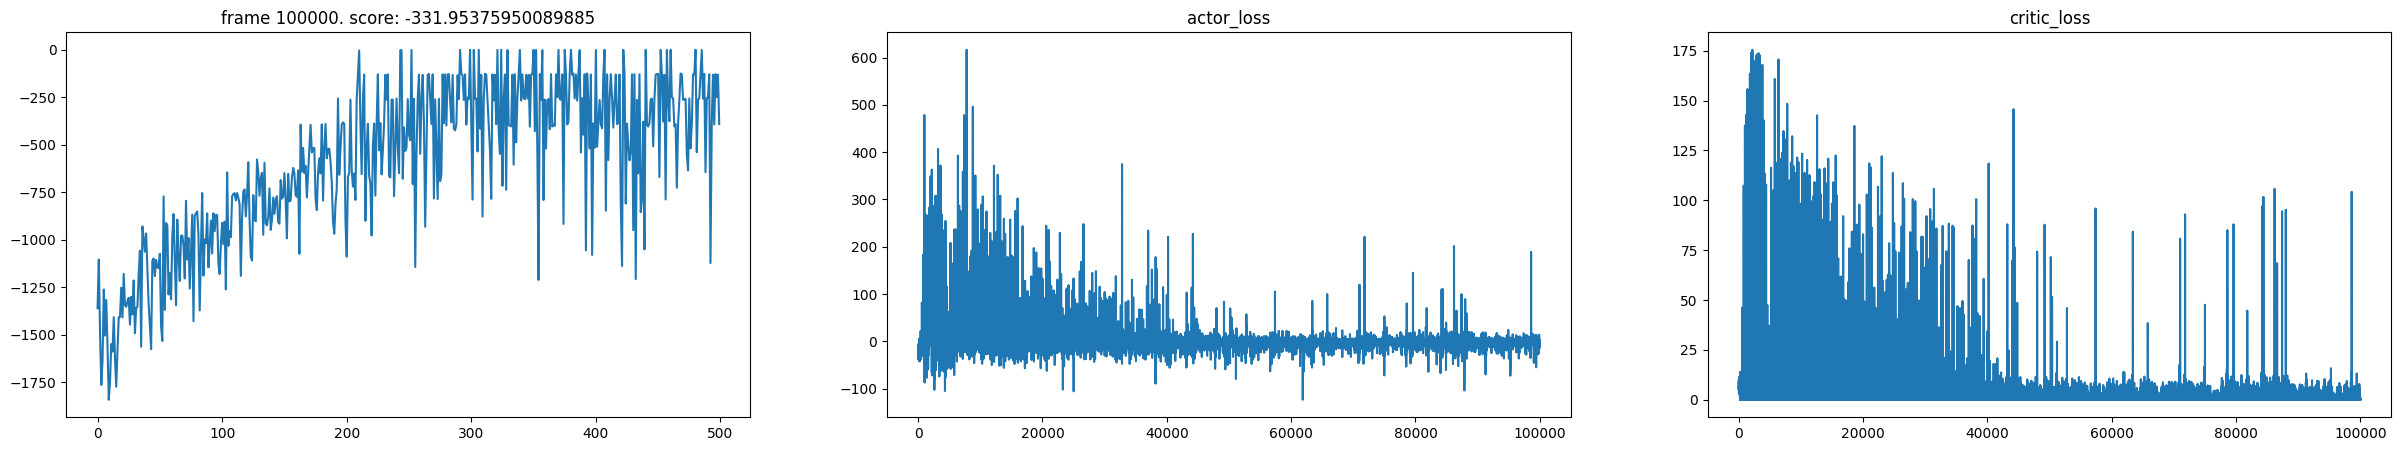

0.0
A better score than the -150  was taken in  59.3 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_frames = 100_000
# Nota: episode truncates at 200 time steps.

gamma = 0.95

boost_explaration_weight =  0

agent = A2CAgent(env, gamma, boost_explaration_weight)

agent.train(num_frames)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()

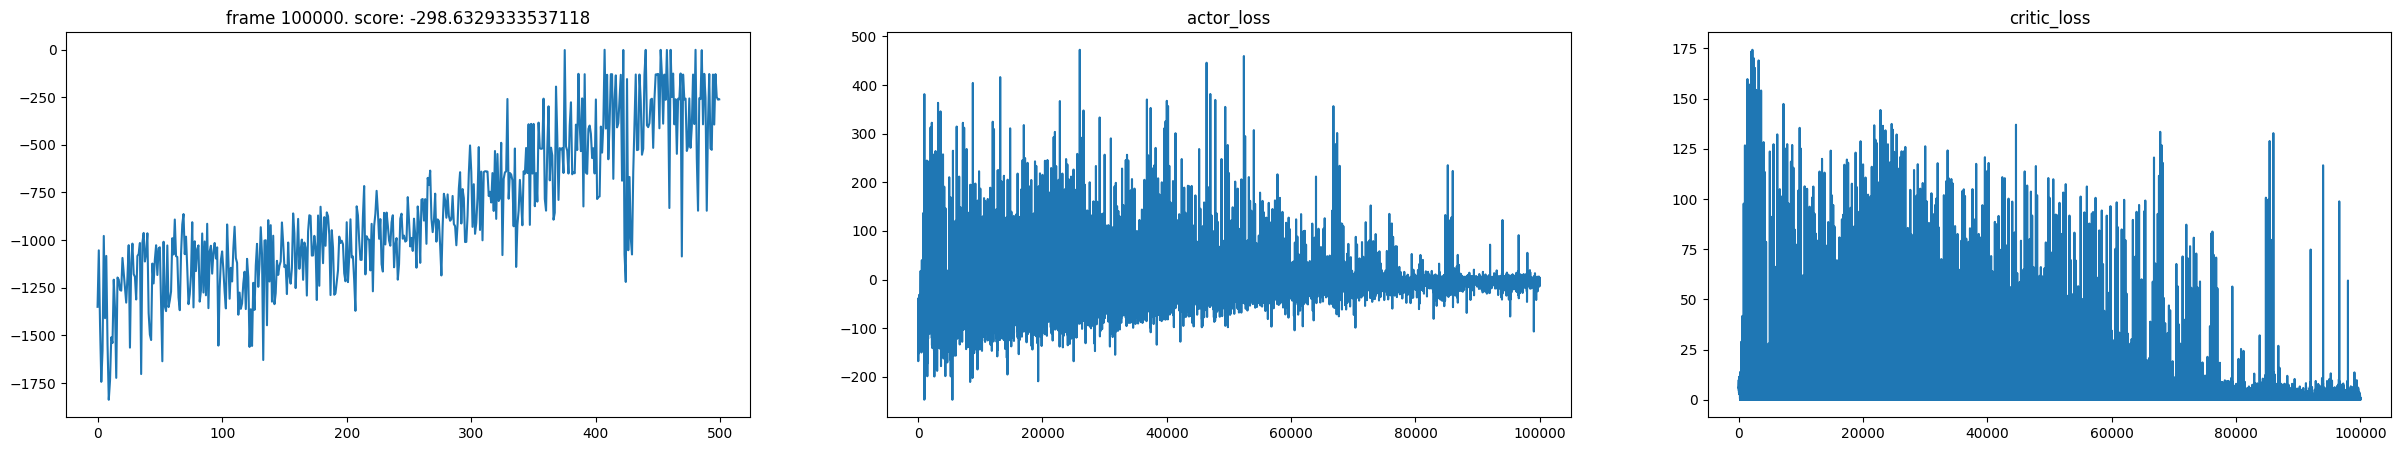

0.0817354287692813
A better score than the -150  was taken in  57.8 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_frames = 100_000
# Nota: episode truncates at 200 time steps.

gamma = 0.95

boost_explaration_weight =  20

agent = A2CAgent(env, gamma, boost_explaration_weight)

agent.train(num_frames)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()


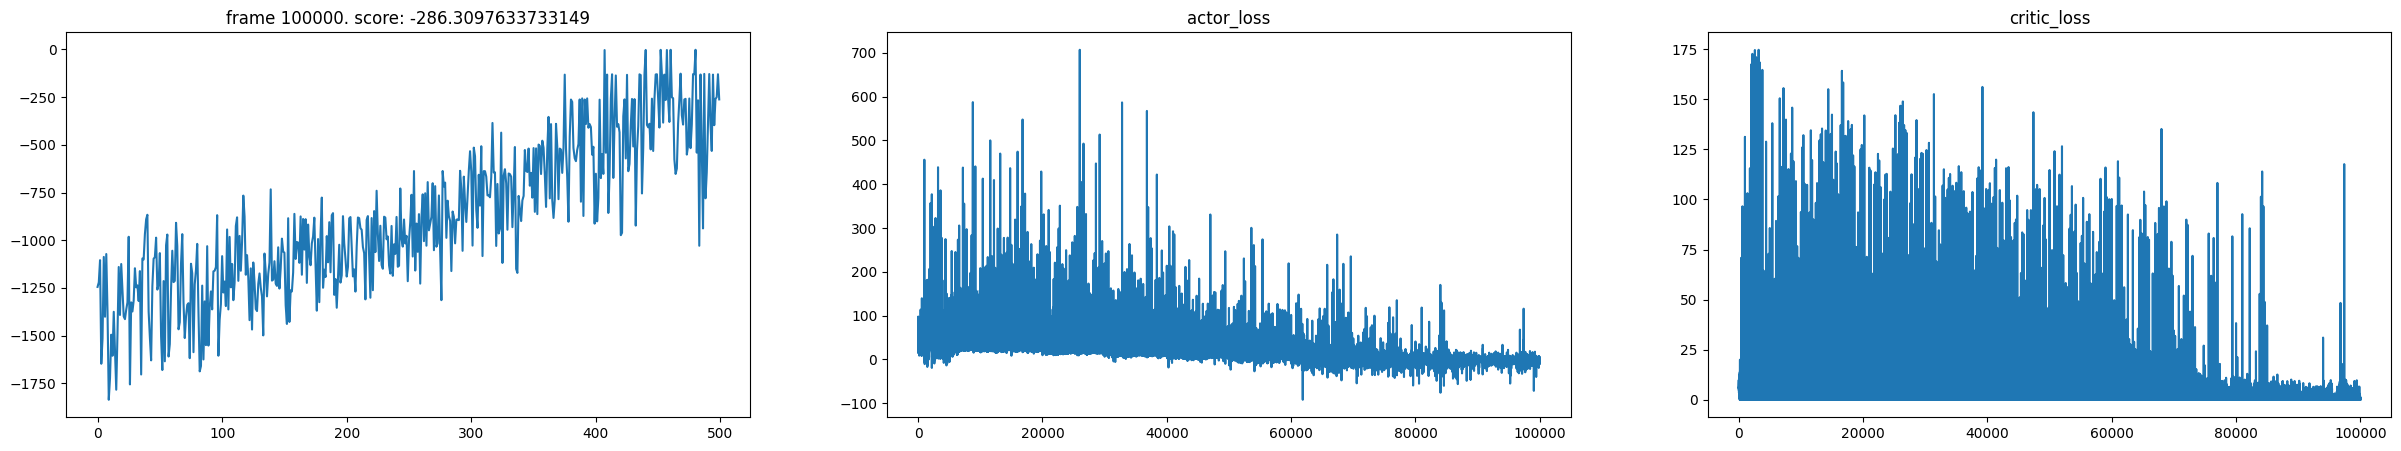

-0.0817354287692813
A better score than the -150  was taken in  56.5 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_frames = 100_000
# Nota: episode truncates at 200 time steps.

gamma = 0.95

boost_explaration_weight = - 20

agent = A2CAgent(env, gamma, boost_explaration_weight)

agent.train(num_frames)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()

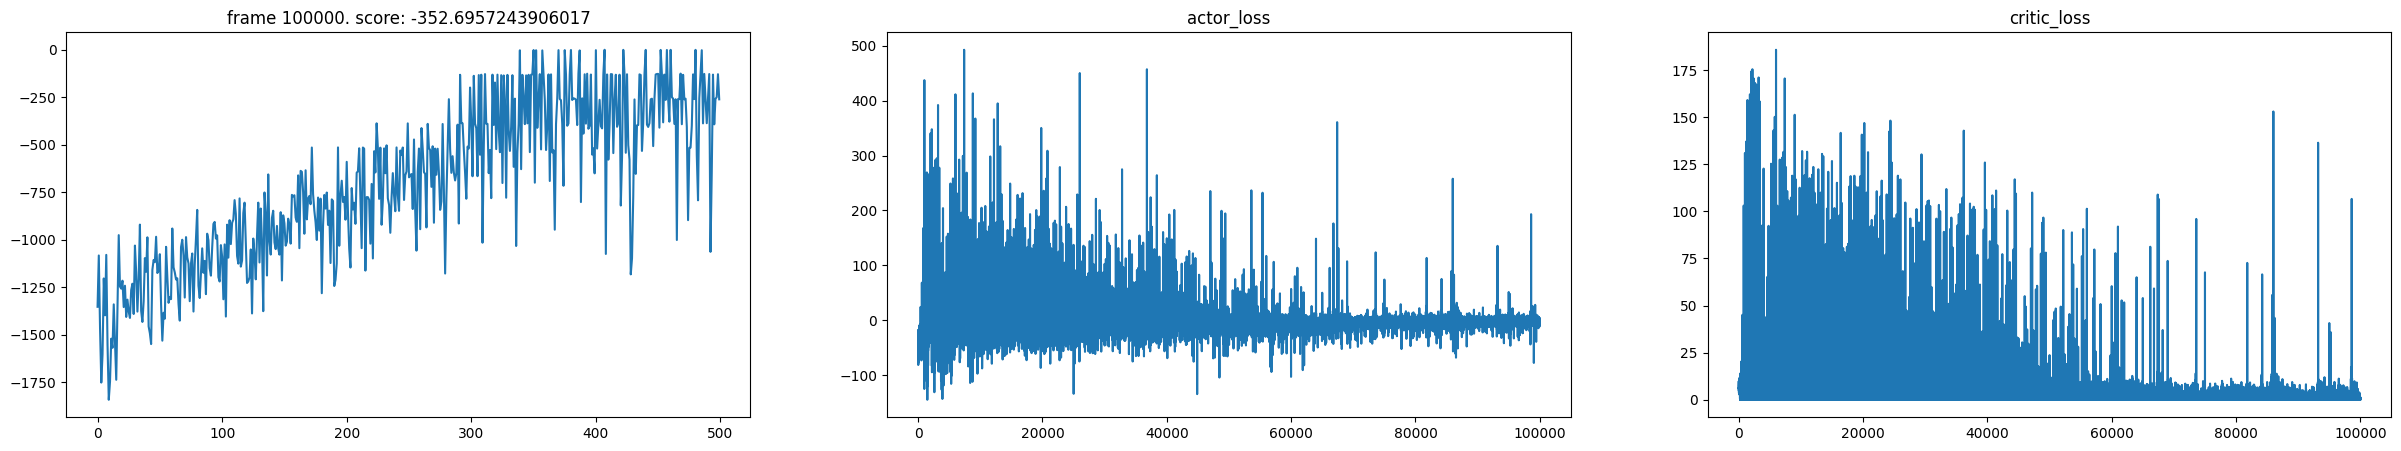

0.02860740006924847
A better score than the -150  was taken in  56.9 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

num_frames = 100_000
# Nota: episode truncates at 200 time steps.

gamma = 0.95

boost_explaration_weight =  7

agent = A2CAgent(env, gamma, boost_explaration_weight)

agent.train(num_frames)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()


#  Sperimentazioni e variazioni sull'algoritmo One-step Actor-Critic:  *step-by-step update* v.s. *episodic update*

In questo codice update dei parametri sarà effettuato esclusivamente al termine di ciascun episodio (*episodic update*), in accordo con una logica più vicina ai principi teorici di base.

Nota:

1.

Per l'aggiornamento dei parametri, verrà utilizzato il valore medio delle varie loss ricavate durante ciascun episodio

2.

Le modifiche apportate al coefficiente di *Entropy regularization* nel calcolo della loss dell'actor, durante questo training, non sono legate dalle modifiche sull'update episodico; seguono uno spirito puramente sperimentale.

In [ ]:
class A2CAgent_updend:

    def __init__(self, env: gym.Env, gamma: float, boost_explaration_weight: float):

        self.env = env
        self.gamma = gamma
        self.boost_explaration_weight = boost_explaration_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print("Device:",self.device)

        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        # networks
        self.actor = Actor(obs_dim, action_dim) #.to(self.device)
        self.critic = Critic(obs_dim)  #.to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # modalità: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        state = torch.FloatTensor(state) #.to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action # se si è in modalità test,
                                                                # sceglie l'azione più probabile : dist.mean
        log_prob = None

        if not self.is_test:
            log_prob = dist.log_prob(selected_action).sum(dim=-1)
            #Nota : Probabilità logaritmiche in  (-inf,0] invece che in [0,1]

        return dist, log_prob, selected_action.clamp(-2.0, 2.0).cpu().detach().numpy()

    def train(self, tot_episod: int = 10_000, plotting_interval: int = 1_000):
        """Fase di Training"""
        self.is_test = False

        actor_losses, critic_losses, scores = [], [], []
        state = self.env.reset(seed=31)
        score = 0

        for self.total_step in range(1, tot_episod + 1):
            saved_critic, saved_actor  = [], []

            # Genera una traiettoria completa
            while True:
              dist, log_prob, action = self.select_action(state)
              next_state, reward, done, _ = self.env.step(action)

              #Calcola e salva le due Loss
              state = torch.FloatTensor(state)
              mask = 1 - done # se: "done == True" allora "mask == 0" quindi: "targ_value = reward"
              next_state = torch.FloatTensor(next_state)#.to(self.device)
              pred_value = self.critic(state)
              targ_value = reward + self.gamma * self.critic(next_state) * mask
              # Critic Loss
              value_loss = F.smooth_l1_loss(pred_value, targ_value.detach())
              # Advantage Function = Q_t - V(s_t)
              advantage =  (targ_value - pred_value).detach()
              policy_loss = advantage * log_prob
              # Entropy regularization
              entropy = dist.entropy()
              policy_loss += (self.boost_explaration_weight * entropy)
              # E' una convenzione standard, sia in PyTorch che TF, eseguire la minimizzazione anziché la massimizzazione.
              policy_loss = - policy_loss
              # Memorizza le loss
              saved_critic.append(value_loss)
              saved_actor.append(policy_loss)
              #Aggiornamenti per realizzare lo step sucessivo
              state = next_state
              score += reward
              #A fine episodio ...
              if done:
                state = env.reset()
                scores.append(score)
                score = 0
                break

            # Ricava il valore medio delle loss dell'episodio
            avg_critic_loss = torch.stack(saved_critic).mean()
            avg_actor_loss = torch.stack(saved_actor).mean()

            # Update critic
            self.critic_optimizer.zero_grad()
            avg_critic_loss.backward()
            self.critic_optimizer.step()

            # Update actor
            self.actor_optimizer.zero_grad()
            avg_actor_loss.backward()
            self.actor_optimizer.step()

            #Per il Plot
            actor_losses.append(avg_actor_loss.item())
            critic_losses.append(avg_critic_loss.item())

            # Plot
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

        self.env.close()

    def test(self):
        """Fase di Testing"""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            #frames.append(self.env.render(mode="rgb_array"))
            _,_,action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward

        self.env.close()

        return frames, score

    def evaluate_agent_performance(self,num_episodes=1_000, baseline_reward=-150):

        #Riferimento per baseline_reward:
        #https://github.com/openai/gym/wiki/Leaderboard

        better_scores_count = 0

        self.is_test = True
        state = self.env.reset(seed=99) # per la sperimentazione un "seed" diverso dal training

        # Run episodes
        for k in range(num_episodes):

          done = False
          score = 0

          while not done:
            _,_,action = self.select_action(state)
            next_state, reward, done, _ = self.env.step(action)

            state = next_state
            score += reward
            #if k == 47:    # testa la riproducibilità
            #  print(state)

          state = env.reset()
          if score > baseline_reward:
             better_scores_count += 1


        # Calcola la percentuale
        success_percentage = (better_scores_count / num_episodes) * 100

        print("A better score than the", baseline_reward, " was taken in ", round(success_percentage,2), "% of times" )

        self.env.close()
        return None

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"Episode {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

#### Sperimentazioni con fattori di Entropia diversi

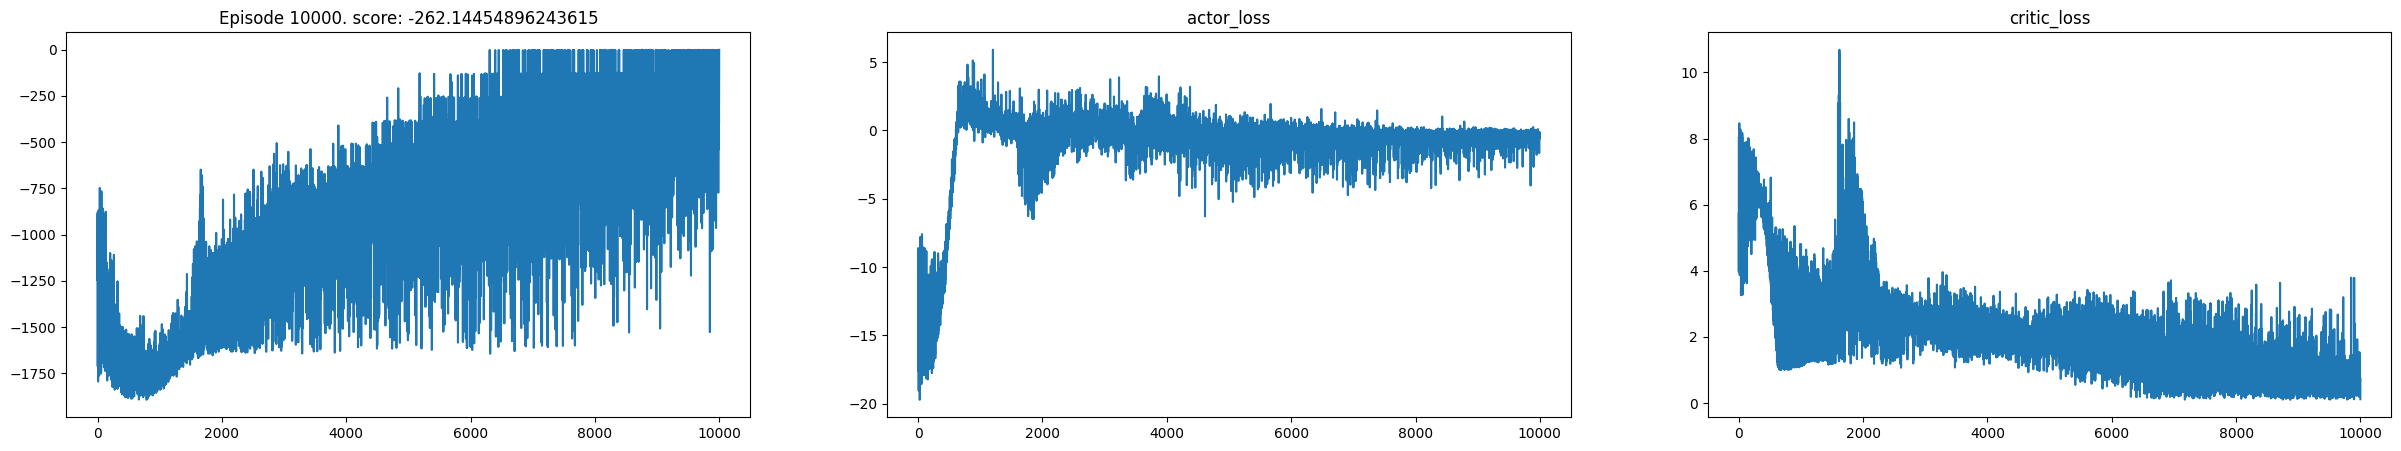

0
A better score than the -150  was taken in  53.9 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

gamma = 0.95
boost_explaration_weight = 0

agent = A2CAgent_updend(env, gamma, boost_explaration_weight)
# Nota: episode truncates at 200 time steps.

agent.train(tot_episod=10_000,plotting_interval= 1_000)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()

In [ ]:
frames,score = agent.test()
print("Score: ", score)

Score:  -265.84460145721994


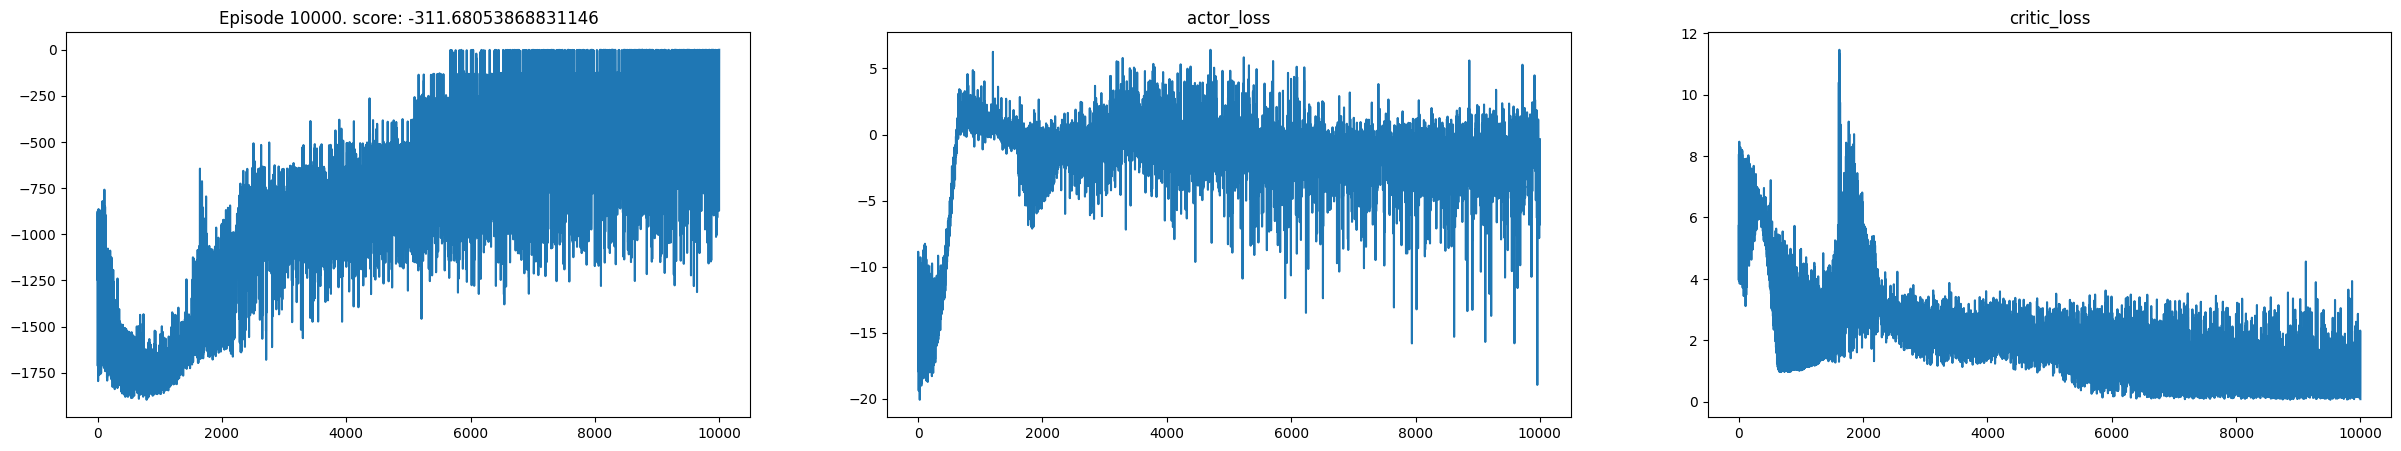

0.15
A better score than the -150  was taken in  40.7 % of times


In [ ]:
#Set Random seed
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 314
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

gamma = 0.95
# il valore del "boost_explaration_weight" rimane costante per tutto il training
boost_explaration_weight = 0.15

agent = A2CAgent_updend(env, gamma, boost_explaration_weight)
# Nota: episode truncates at 200 time steps.

agent.train(tot_episod=10_000,plotting_interval= 2_000)
print(agent.boost_explaration_weight)
agent.evaluate_agent_performance()

In [ ]:
frames,score = agent.test()
print("Score: ", score)

Score:  -0.1616826936220289


In [ ]:
frames,score = agent.test()
print("Score: ", score)

Score:  -131.56996469069628


Nota finale:

La durata complessiva di questo training si aggira sui 50 minuti.

Mentre per il primo codice la durata è pari un tempo di 6 minuti